<h1><center>PUC MG - Pontifícia Universidade Católica de Minas Gerais</center></h1>

<h2><center>Pós-Graduação em Ciência de Dados e Big Data</center></h2>

<h3><center>TRABALHO DE CONCLUSÃO DE CURSO</center><br>
TÍTULO: PREVISÃO DOS PREÇOS DE AÇÕES COM SÉRIES TEMPORAIS DA BOLSA DE VALORES<br>
ALUNO: Roberta Fonseca Santos de Paula</h3>

<p>Este notebook é referente ao Trabalho de Conclusão de Curso em Ciência de Dados e Big Data. Para o desenvolvimento deste trabalho foi utilizada a API Yahoo Finance para obtenção dos datasets das ações analisadas.</p>

<h3>CARREGAMENTO E TRATAMENTO DOS DADOS:</h3>

In [1]:
%matplotlib inline

# Bibliotecas básicas do python

import csv
import numpy as np 
import seaborn as sns
import pandas as pd
from pandas import DataFrame
from pandas_datareader import data
import matplotlib.pyplot as plt
import datetime
import math

#Bibliotecas para utilização do Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

#Bibliotecas para utilização do ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
import pmdarima as pm

#Bibliotecas para utilização do Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout, Masking, Embedding

#Bibliotecas para utilização das métricas do Sklearn
import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Bibliotecas para uso do statsmodels
import statsmodels.api as sm
from scipy import stats

#Biblioteca para ignorar os warnings
import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


<p>As ações analisadas são: Banco do Brasil (BBAS3.SA), Banco Bradesco (BBDC4.SA) e Banco Itaú (ITUB4.SA). Sendo que os modelos de Machine Learning utilizados são para previsão do ano de 2020 das ações mensionadas. Para os modelos de previsão, os dados de treinamento utilizam o início do ano de 2015 até o fim de 2019.</p>

In [2]:
# Escolha do período a ser utilizado no treinamento:

train_start_date = '2015-01-01'
train_end_date = '2019-12-31'

# Escolha do período a ser utilizado nos testes:

test_start_date = '2020-01-01'
test_end_date = '2020-12-31'

In [3]:
# Escolha das ações a serem analisadas:

actions = ['BBAS3.SA', 'BBDC4.SA', 'ITUB4.SA']

In [4]:
# Utilização do pandas_datareader para carregar os dados de treinamento do Yahoo Finance:

train_dataset_bbas3 = data.DataReader(actions[0], 'yahoo', train_start_date, train_end_date)
train_dataset_bbdc4 = data.DataReader(actions[1], 'yahoo', train_start_date, train_end_date)
train_dataset_itub4 = data.DataReader(actions[2], 'yahoo', train_start_date, train_end_date)

In [5]:
# Utilização do pandas_datareader para carregar os dados de teste do Yahoo Finance:

test_dataset_bbas3 = data.DataReader(actions[0], 'yahoo', test_start_date, test_end_date)

<p>Os datasets contém 7 colunas cada, sendo o índice a coluna Date:
<ul>
  <li>Date: Data da negociação</li>
  <li>High: Maior preço da ação no dia</li>
  <li>Low: Menor preço da ação no dia</li>
  <li>Open: Preço de abertura da ação no dia</li>
  <li>Close: Preço de fechamento da ação no dia</li>
  <li>Volume: Volume total negociado no dia</li>
  <li>Adj Close: Valor ajustado da ação no dia. Considera desconto de dividentos, splits, inplits, etc</li>
</ul>

Neste trabalho, a coluna utilizada nos modelos de predição é o preço de fechamento (Close).</p>

<h2>ANÁLISE EXPLORATÓRIA DOS DATASETS:</h2>

<h3>Ação BBAS3.SA</h3>

In [ ]:
# Exibe os tipos das colunas do dataset da BBAS3

train_dataset_bbas3.dtypes

In [ ]:
# Exibe as primeiras linhas do dataset

train_dataset_bbas3.head()

In [13]:
# Descrição estatística do conjunto de dados do Banco do Brasil

train_dataset_bbas3.describe()

In [14]:
# Verifica se a BBAS3 tem algum valor nulo

train_dataset_bbas3.isnull().sum()

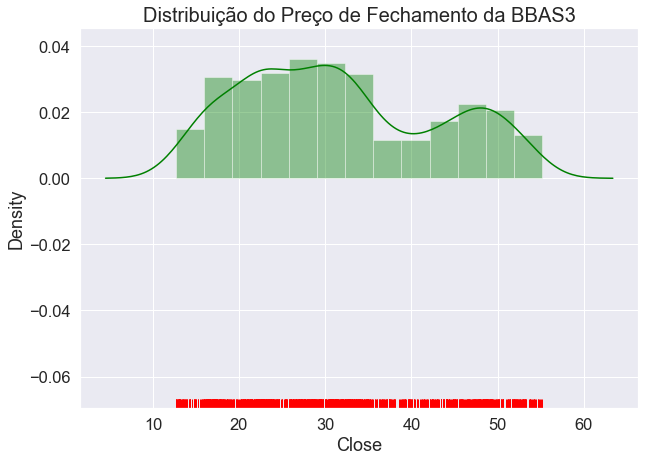

In [22]:
# Plotagem do histograma da distribuição da BBAS3 utilizando as datas de fechamento do dia

plt.figure(figsize=(10,7))
sns.set_context('notebook', font_scale=1.5, rc={'font.size':20, 'axes.titlesize':20, 'axes.labelsize':18})
sns.rugplot(train_dataset_bbas3['Close'], color= 'red')
sns.distplot(train_dataset_bbas3['Close'], color= 'green')
sns.set_style('darkgrid')
plt.title('Distribuição do Preço de Fechamento da BBAS3')

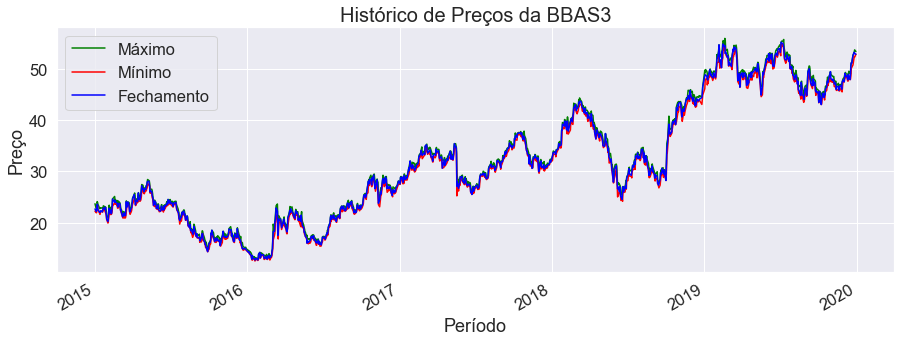

In [21]:
# Plotagem da série histórica

plt.figure(figsize=(15,5))
train_dataset_bbas3['High'].plot(label = 'Máximo', color = 'green')
train_dataset_bbas3['Low'].plot(label = 'Mínimo', color = 'red')
train_dataset_bbas3 ['Close'].plot(label = 'Fechamento', color = 'blue')
plt.ylabel('Preço')
plt.xlabel('Período')
plt.title('Histórico de Preços da BBAS3')
plt.legend();

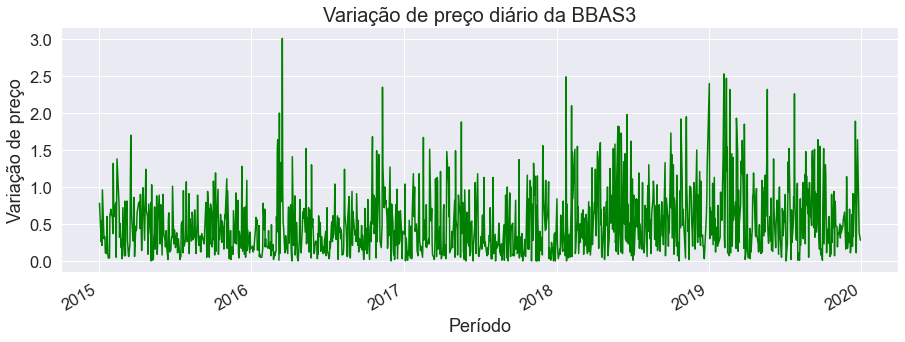

In [23]:
# Plotagem da variação de preço diária Valor absoluto (preço de fechamento - preço de abertura)

variation_bbas3 = abs(train_dataset_bbas3['Close'] - train_dataset_bbas3['Open'])
plt.figure(figsize=(15,5))
variation_bbas3.plot(label = 'Variação de preço', color = 'green')
plt.ylabel('Variação de preço')
plt.xlabel('Período')
plt.title('Variação de preço diário da BBAS3')

In [ ]:
# Retorna a data com a maior variação entre o preço de abertura e fechamento

max_variation_bbas3 = variation_bbas3.values.argmax()
max_value_bbas3 = variation_bbas3.values[max_variation_bbas3,]
variation_bbas3[variation_bbas3.values == max_value_bbas3]

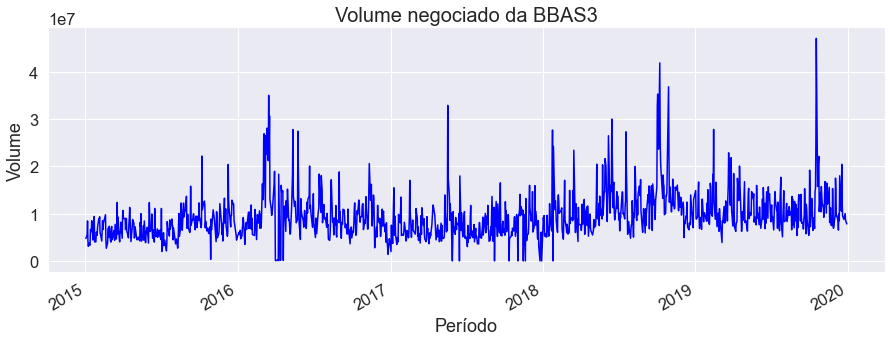

In [24]:
# Plotagem do volume negociado no período

plt.figure(figsize=(15,5))
train_dataset_bbas3['Volume'].plot(label = 'Volume', color = 'blue')
plt.ylabel('Volume')
plt.xlabel('Período')
plt.title('Volume negociado da BBAS3')

In [25]:
# Retorna a data com o maior volume de negociação

max_volume_bbas3 = train_dataset_bbas3['Volume'].argmax()
train_dataset_bbas3.iloc[max_volume_bbas3,:]

High         4.655000e+01
Low          4.550000e+01
Open         4.600000e+01
Close        4.606000e+01
Volume       4.711660e+07
Adj Close    3.942318e+01
Name: 2019-10-18 00:00:00, dtype: float64

<h3>Ação BBDC4.SA</h3>

In [ ]:
# Exibe as primeiras linhas dos dados da BBDC4

train_dataset_bbdc4.head()

In [26]:
# Descrição estatística do conjunto de dados da BBDC4

train_dataset_bbdc4.describe()

In [27]:
# Verifica se a BBDC4 tem algum valor nulo

train_dataset_bbdc4.isnull().sum() 

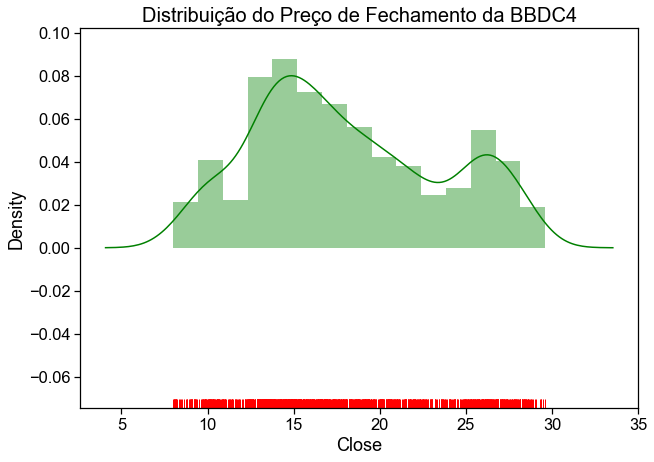

In [6]:
# Plotagem do histograma da distribuição da BBDC4 utilizando as datas de fechamento do dia

plt.figure(figsize=(10,7))
sns.set_context('notebook', font_scale=1.5, rc={'font.size':20, 'axes.titlesize':20, 'axes.labelsize':18})
sns.rugplot(train_dataset_bbdc4['Close'], color= 'red')
sns.distplot(train_dataset_bbdc4['Close'], color= 'green')
sns.set_style('darkgrid')
plt.title('Distribuição do Preço de Fechamento da BBDC4')

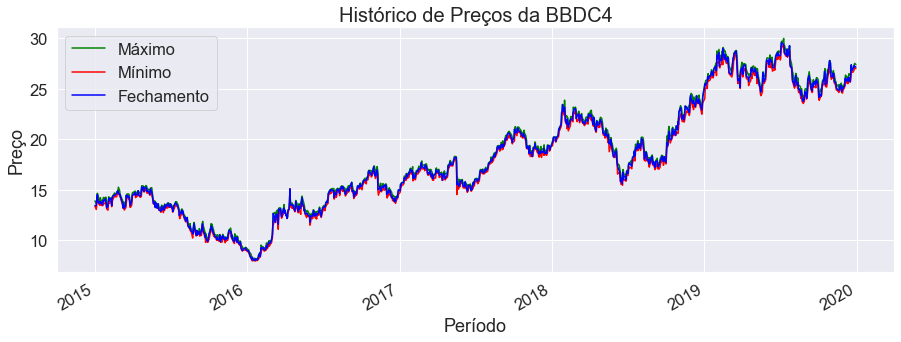

In [7]:
# Plotagem da série histórica

plt.figure(figsize=(15,5))
train_dataset_bbdc4['High'].plot(label = 'Máximo', color = 'green')
train_dataset_bbdc4['Low'].plot(label = 'Mínimo', color = 'red')
train_dataset_bbdc4['Close'].plot(label = 'Fechamento', color = 'blue')
plt.ylabel('Preço')
plt.xlabel('Período')
plt.title('Histórico de Preços da BBDC4')
plt.legend();

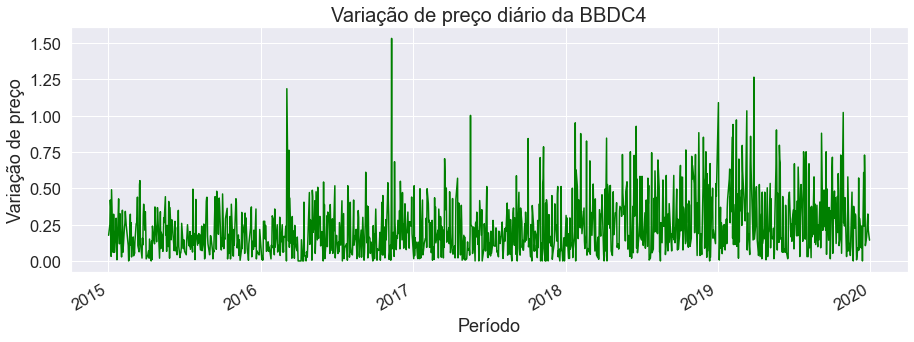

In [8]:
# Plotagem da variação de preço diária Valor absoluto (preço de fechamento - preço de abertura)

variation_bbdc4 = abs(train_dataset_bbdc4['Close'] - train_dataset_bbdc4['Open'])
plt.figure(figsize=(15,5))
variation_bbdc4.plot(label = 'Variação de preço', color = 'green')
plt.ylabel('Variação de preço')
plt.xlabel('Período')
plt.title('Variação de preço diário da BBDC4')

In [31]:
# Retorna a data com a maior variação entre o preço de abertura e fechamento

max_variation_bbdc4 = variation_bbdc4.values.argmax()
max_value_bbdc4 = variation_bbdc4.values[max_variation_bbdc4,]
variation_bbdc4[variation_bbdc4.values == max_value_bbdc4]

Date
2016-11-10    1.531606
dtype: float64

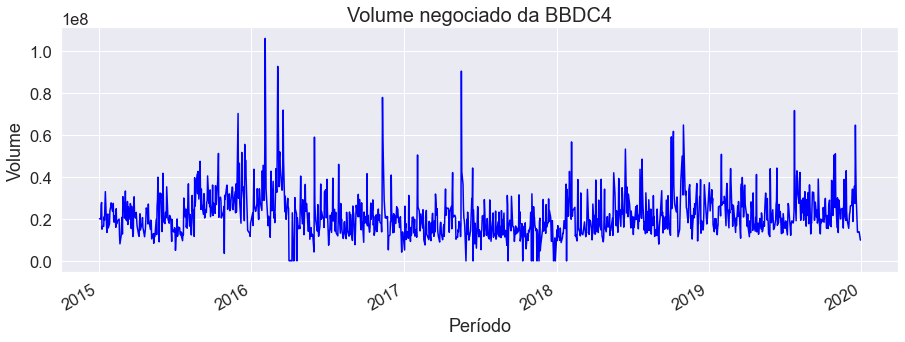

In [9]:
# Plotagem do volume negociado no período

plt.figure(figsize=(15,5))
train_dataset_bbdc4['Volume'].plot(label = 'Volume', color = 'blue')
plt.ylabel('Volume')
plt.xlabel('Período')
plt.title('Volume negociado da BBDC4')

In [34]:
# Retorna a data com o maior volume de negociação

max_volume_bbdc4 = train_dataset_bbdc4['Volume'].argmax()
train_dataset_bbdc4.iloc[max_volume_bbdc4,:]

High         8.979839e+00
Low          8.636451e+00
Open         8.843424e+00
Close        8.801089e+00
Volume       1.060292e+08
Adj Close    6.696978e+00
Name: 2016-02-03 00:00:00, dtype: float64

<h3>Ação ITUB4.SA</h3>

In [ ]:
# Exibe as primeiras linhas dos dados da ITUB4

train_dataset_itub4.head()

In [35]:
# Descrição estatística do conjunto de dados da ITUB4

train_dataset_itub4.describe()

In [36]:
# Verifica se a ITUB4 tem algum valor nulo

train_dataset_itub4.isnull().sum() 

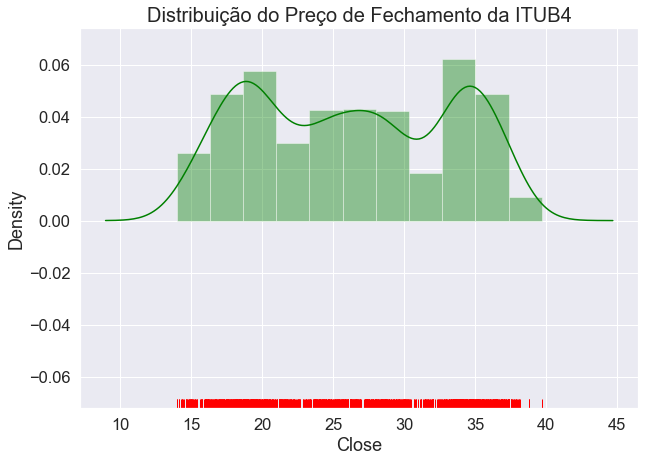

In [10]:
# Plotagem do histograma da distribuição da ITUB4 utilizando as datas de fechamento do dia

plt.figure(figsize=(10,7))
sns.set_context('notebook', font_scale=1.5, rc={'font.size':20, 'axes.titlesize':20, 'axes.labelsize':18})
sns.rugplot(train_dataset_itub4['Close'], color= 'red')
sns.distplot(train_dataset_itub4['Close'], color= 'green')
sns.set_style('darkgrid')
plt.title('Distribuição do Preço de Fechamento da ITUB4')

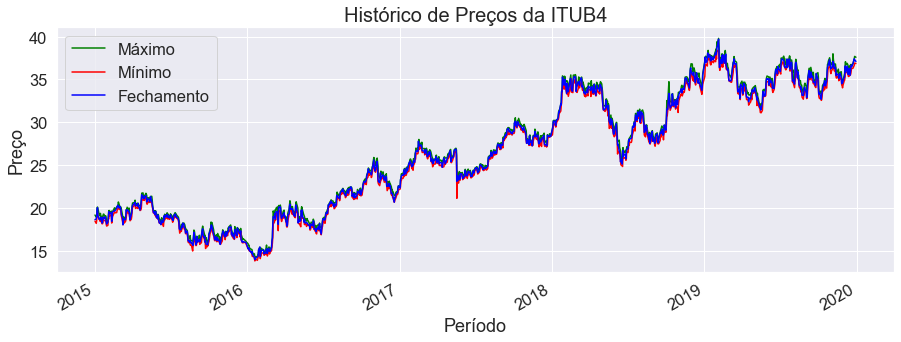

In [11]:
# Plotagem da série histórica

plt.figure(figsize=(15,5))
train_dataset_itub4['High'].plot(label = 'Máximo', color = 'green')
train_dataset_itub4['Low'].plot(label = 'Mínimo', color = 'red')
train_dataset_itub4['Close'].plot(label = 'Fechamento', color = 'blue')
plt.ylabel('Preço')
plt.xlabel('Período')
plt.title('Histórico de Preços da ITUB4')
plt.legend();

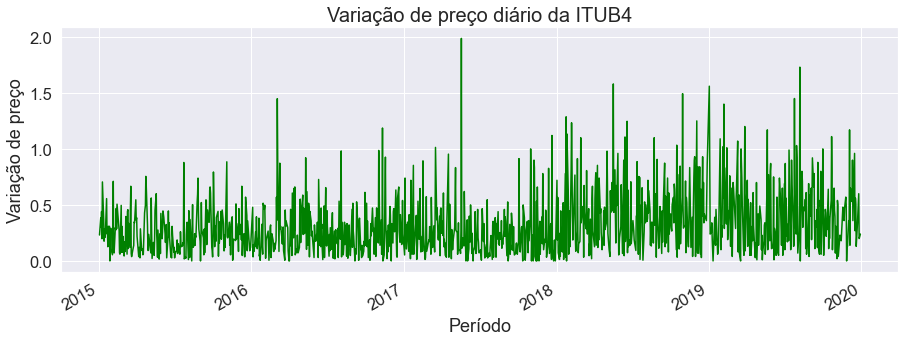

In [12]:
# Plotagem da variação de preço diária Valor absoluto (preço de fechamento - preço de abertura)

variation_itub4 = abs(train_dataset_itub4['Close'] - train_dataset_itub4['Open'])
plt.figure(figsize=(15,5))
variation_itub4.plot(label = 'Variação de preço', color = 'green')
plt.ylabel('Variação de preço')
plt.xlabel('Período')
plt.title('Variação de preço diário da ITUB4')

In [40]:
# Retorna a data com a maior variação entre o preço de abertura e fechamento

max_variation_itub4 = variation_itub4.values.argmax()
max_value_itub4 = variation_itub4.values[max_variation_itub4,]
variation_itub4[variation_itub4.values == max_value_itub4]

Date
2017-05-18    1.986668
dtype: float64

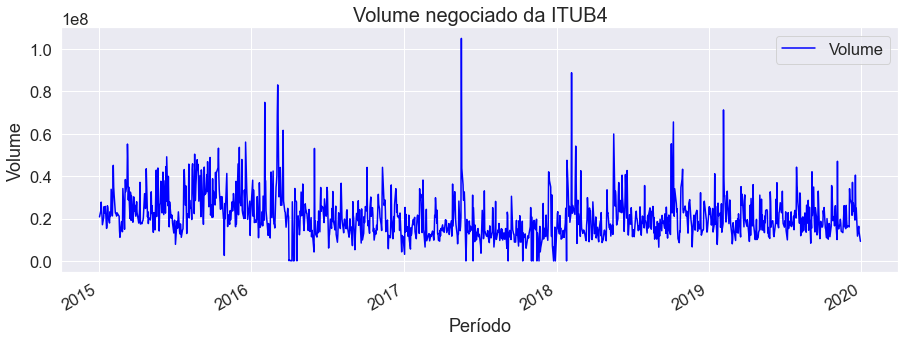

In [13]:
# Plotagem do volume negociado no período

plt.figure(figsize=(15,5))
train_dataset_itub4['Volume'].plot(label = 'Volume', color = 'blue')
plt.ylabel('Volume')
plt.xlabel('Período')
plt.title('Volume negociado da ITUB4')
plt.legend();

In [42]:
# Retorna a data com o maior volume de negociação

max_volume_itub4 = train_dataset_itub4['Volume'].argmax()
train_dataset_itub4.iloc[max_volume_itub4,:]

High         2.396000e+01
Low          2.113333e+01
Open         2.113333e+01
Close        2.312000e+01
Volume       1.049172e+08
Adj Close    1.910074e+01
Name: 2017-05-18 00:00:00, dtype: float64

<h2>Análise das ações em conjunto:</h2>
<h3>Comparativo de retorno utilizando o valor ajustado das ações</h3>

In [6]:
# Extrai os preços ajustados do fechamento de todas as ações e transforma em um único dataset para tratamento em conjunto

train_dataset_adj_bbas3 = train_dataset_bbas3.loc[:, ['Adj Close']]
train_dataset_adj_bbas3.rename(columns={'Adj Close': 'BBAS3'}, inplace=True)
train_dataset_adj_bbdc4 = train_dataset_bbdc4.loc[:, ['Adj Close']]
train_dataset_adj_bbdc4.rename(columns={'Adj Close': 'BBDC4'}, inplace=True)
train_dataset_adj_itub4 = train_dataset_itub4.loc[:, ['Adj Close']]
train_dataset_adj_itub4.rename(columns={'Adj Close': 'ITUB4'}, inplace=True)
train_dataset_adj = pd.concat([train_dataset_adj_bbas3, train_dataset_adj_bbdc4, train_dataset_adj_itub4], axis=1)
train_dataset_adj.head()

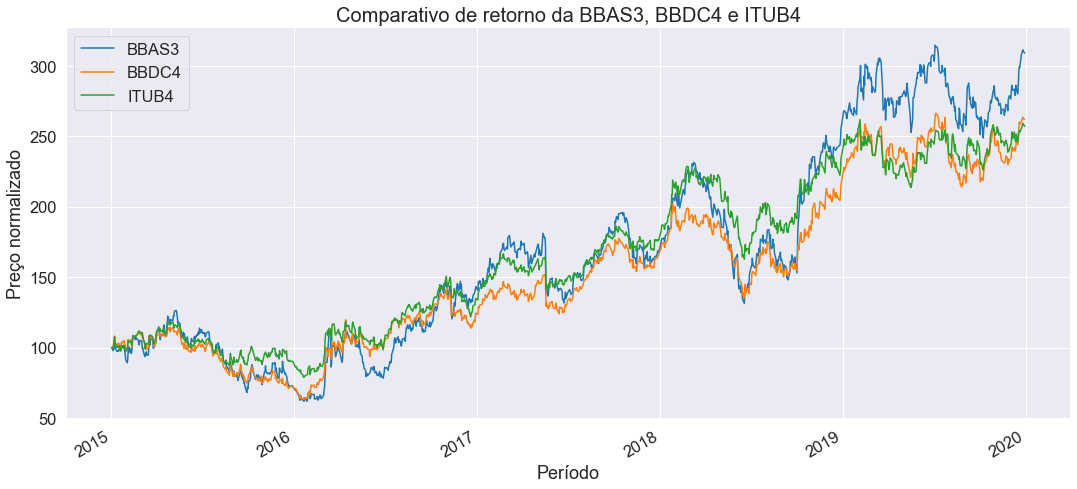

<Figure size 432x288 with 0 Axes>

In [16]:
# Gráfico normalizado

(train_dataset_adj/train_dataset_adj.iloc[0]*100).plot(figsize=(18,8))
plt.ylabel('Preço normalizado')
plt.xlabel('Período')
plt.title('Comparativo de retorno da BBAS3, BBDC4 e ITUB4')
plt.show()

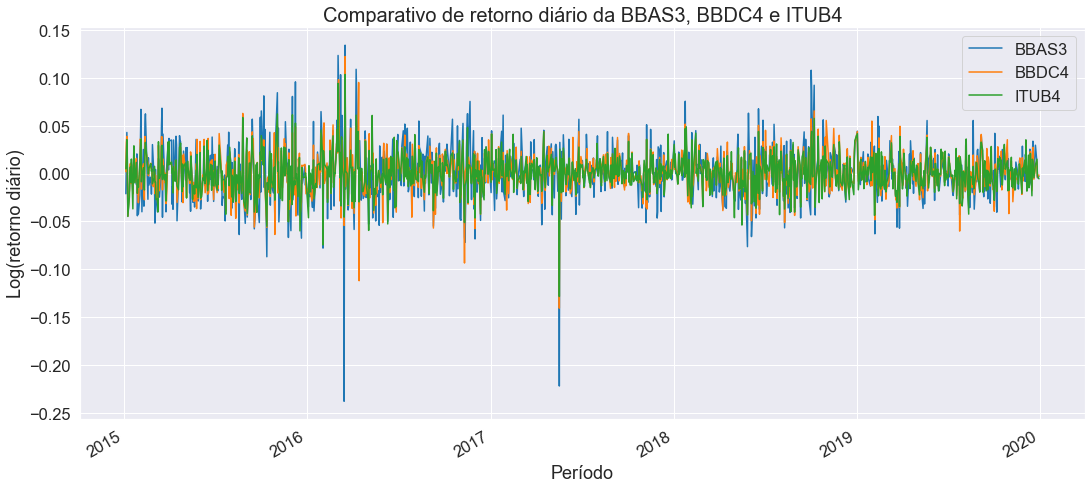

<Figure size 432x288 with 0 Axes>

In [17]:
# Retorno diário

log_returns=np.log(train_dataset_adj/train_dataset_adj.shift(1))
log_returns.plot(figsize=(18,8))
plt.ylabel('Log(retorno diário)')
plt.xlabel('Período')
plt.title('Comparativo de retorno diário da BBAS3, BBDC4 e ITUB4')
plt.show()

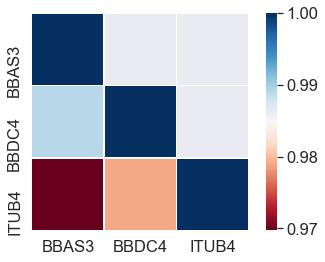

In [21]:
# Função para criação do mapa de correlação das ações

def plot_correlation(corr):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask, 1)] = True
    sns.heatmap(corr, mask=mask, cmap='RdBu', square=True, linewidths=.5)
    
# Cálculo da correlação

corr = train_dataset_adj.corr()
plot_correlation(corr)

In [15]:
# Retorno médio diário

log_returns.mean()

BBAS3    0.000908
BBDC4    0.000776
ITUB4    0.000760
dtype: float64

In [52]:
# Percentual de retorno anual

(log_returns.mean()*250)*100

In [16]:
# Risco

log_returns.std()

BBAS3    0.027639
BBDC4    0.020893
ITUB4    0.018722
dtype: float64

<h2>MODELOS PREDITIVOS PARA A AÇÃO BBAS3:</h2>
<p>O dataset de treinamento utiliza o período do início de 2015 até o fim de 2019 para prever o ano de 2020.</p>
<h3>Modelo preditivo com o Facebook Prophet</h3>

In [15]:
# Carregamento dos dados de treinamento e teste

train_bbas3_prophet = train_dataset_bbas3
test_bbas3_prophet = test_dataset_bbas3

In [16]:
# Remoção das colunas não utilizadas dos dados de treinamento e teste

train_bbas3_prophet = train_bbas3_prophet.drop(columns = ["Open", "High", "Low", "Volume", "Adj Close"])
test_bbas3_prophet = test_bbas3_prophet.drop(columns = ["Open", "High", "Low", "Volume", "Adj Close"])
train_bbas3_prophet.head()

In [19]:
# Renomeia as colunas 'Close' para 'y' e 'Date' para 'ds' do conjunto de treinamento

train_bbas3_prophet = pd.DataFrame({"ds": train_bbas3_prophet.index, "y": train_bbas3_prophet.Close})
train_bbas3_prophet.reset_index(drop = True, inplace = True)
train_bbas3_prophet.head()

,ds,y
0,2015-01-02,22.650000
1,2015-01-05,22.180000
2,2015-01-06,22.490000
3,2015-01-07,23.480000
4,2015-01-08,23.559999


In [20]:
# Renomeia as colunas 'Close' para 'y_test' e 'Date' para 'ds_test' do conjunto de teste

test_bbas3_prophet = pd.DataFrame({"ds_test": test_bbas3_prophet.index, "y_test": test_bbas3_prophet.Close})
test_bbas3_prophet.reset_index(drop = True, inplace = True)
test_bbas3_prophet.head()

,ds_test,y_test
0,2020-01-02,53.799999
1,2020-01-03,53.709999
2,2020-01-06,53.000000
3,2020-01-07,52.599998
4,2020-01-08,52.119999


In [21]:
# Utiliza a biblioteca Prophet para fazer a previsão

prophet_model = Prophet(changepoint_prior_scale=0.05, interval_width=0.95, daily_seasonality=False)
prophet_model.fit(train_bbas3_prophet)

In [22]:
# Cria datas futuras e faz a previsão

prophet_forecast = prophet_model.make_future_dataframe(periods=365, freq='D')
prophet_forecast = prophet_model.predict(prophet_forecast)

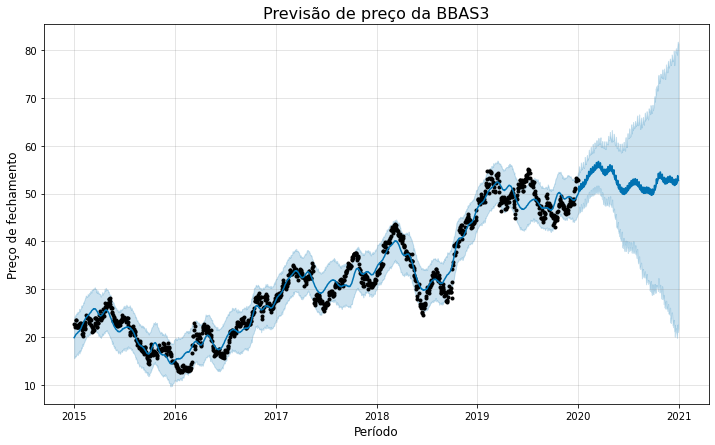

In [23]:
# Plotagem do gráfico de previsão

fig = prophet_model.plot(prophet_forecast)
ax1 = fig.gca()
ax1.set_title("Previsão de preço da BBAS3", fontsize=16)
ax1.set_xlabel("Período", fontsize=12)
ax1.set_ylabel("Preço de fechamento", fontsize=12)

In [24]:
# Seleciona os dados previstos apenas para o período de teste

prophet_forecast = prophet_forecast[prophet_forecast['ds'] > train_end_date]
prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1244,2020-01-01,50.944228,45.795964,54.421923,50.944228,50.944228,-0.997826,-0.997826,-0.997826,-0.337305,-0.337305,-0.337305,-0.660520,-0.660520,-0.660520,0.0,0.0,0.0,49.946403
1245,2020-01-02,50.952817,45.800042,53.904970,50.952817,50.952817,-0.913674,-0.913674,-0.913674,-0.363812,-0.363812,-0.363812,-0.549861,-0.549861,-0.549861,0.0,0.0,0.0,50.039143
1246,2020-01-03,50.961405,46.006345,54.832469,50.957075,50.961405,-0.730050,-0.730050,-0.730050,-0.286123,-0.286123,-0.286123,-0.443926,-0.443926,-0.443926,0.0,0.0,0.0,50.231355
1247,2020-01-04,50.969994,46.469169,55.712850,50.959923,50.969994,0.512929,0.512929,0.512929,0.856665,0.856665,0.856665,-0.343736,-0.343736,-0.343736,0.0,0.0,0.0,51.482922
1248,2020-01-05,50.978582,47.291963,55.599091,50.953572,50.982175,0.606587,0.606587,0.606587,0.856665,0.856665,0.856665,-0.250078,-0.250078,-0.250078,0.0,0.0,0.0,51.585169


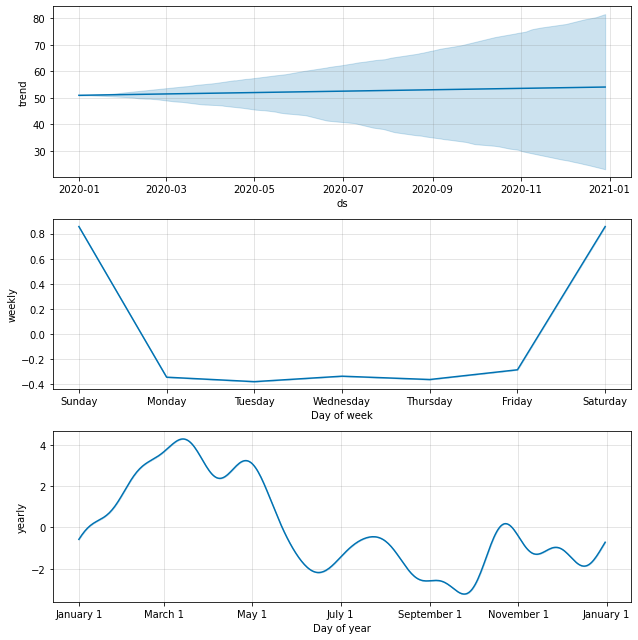

In [26]:
# Plotagem dos componentes da previsão

fig = prophet_model.plot_components(prophet_forecast)

In [27]:
# Exclusão dos fins de semana nos dados previstos

prophet_forecast = prophet_forecast[prophet_forecast['ds'].dt.dayofweek < 5]

# Exclusão dos feriados nos dados previstos

holidays = pd.DataFrame({
    'holiday': 'holiday',
    'ds': pd.to_datetime(['2020-01-01','2020-01-25','2020-02-24','2020-02-25','2020-04-10','2020-04-21','2020-05-01','2020-06-11','2020-09-07','2020-10-12','2020-11-02','2020-11-20','2020-12-24','2020-12-25','2020-12-31']),
})

prophet_forecast = prophet_forecast[~prophet_forecast['ds'].isin(holidays['ds'])]
prophet_forecast = prophet_forecast.dropna()

In [28]:
# Escolhe as datas ('ds' e 'ds_test') como índices

prophet_forecast.set_index(prophet_forecast['ds'], inplace=True) 
test_bbas3_prophet.set_index(test_bbas3_prophet['ds_test'], inplace=True)
train_bbas3_prophet.set_index(train_bbas3_prophet['ds'], inplace=True) 

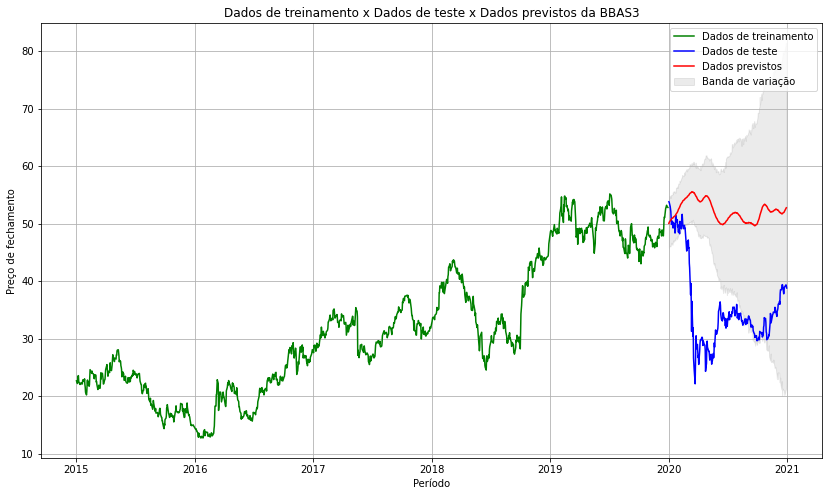

In [29]:
# Plotagem do comparativo entre o preço previsto e o dataset

n = train_bbas3_prophet.shape[0]
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos da BBAS3')
plt.plot(train_bbas3_prophet['y'], 'green', label='Dados de treinamento')
plt.plot(test_bbas3_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'][-n:], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Preço de fechamento")
plt.legend()
plt.grid(True)

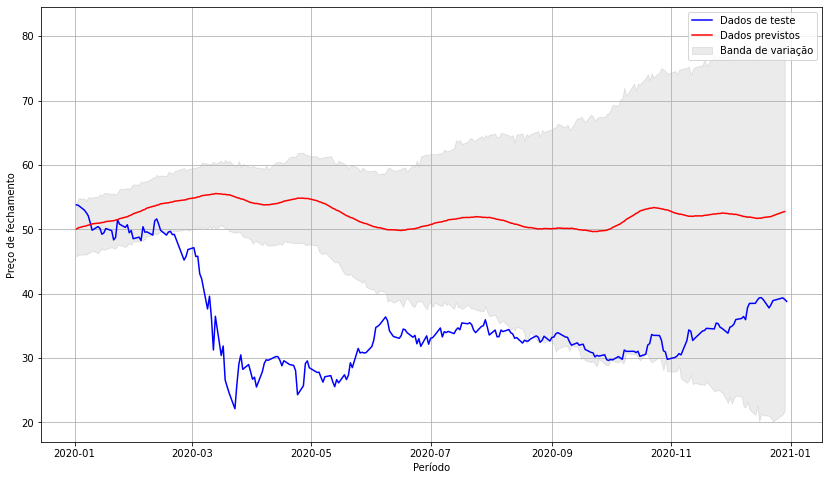

In [30]:
# Plotagem do comparativo entre o preço previsto e o preço de validação

plt.figure(figsize=(14,8))
plt.plot(test_bbas3_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Preço de fechamento")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Cálculo do erro

print('MAE: ', mean_absolute_error(test_bbas3_prophet['y_test'],prophet_forecast['yhat']))
print('MSE: ', mean_squared_error(test_bbas3_prophet['y_test'],prophet_forecast['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(test_bbas3_prophet['y_test'],prophet_forecast['yhat'])))

ValueError: Found input variables with inconsistent numbers of samples: [248, 247]

<h3>Modelo preditivo com AUTO-ARIMA</h3>

In [33]:
# Carregamento dos dados

train_bbas3_arima = train_dataset_bbas3
train_bbas3_arima = train_bbas3_arima.drop(['Adj Close','Open','Low','High','Volume'], axis=1)
test_bbas3_arima = test_dataset_bbas3
test_bbas3_arima = test_bbas3_arima.drop(['Adj Close','Open','Low','High','Volume'], axis=1)
train_bbas3_arima.head()

,Close
Date,
2015-01-02,22.650000
2015-01-05,22.180000
2015-01-06,22.490000
2015-01-07,23.480000
2015-01-08,23.559999


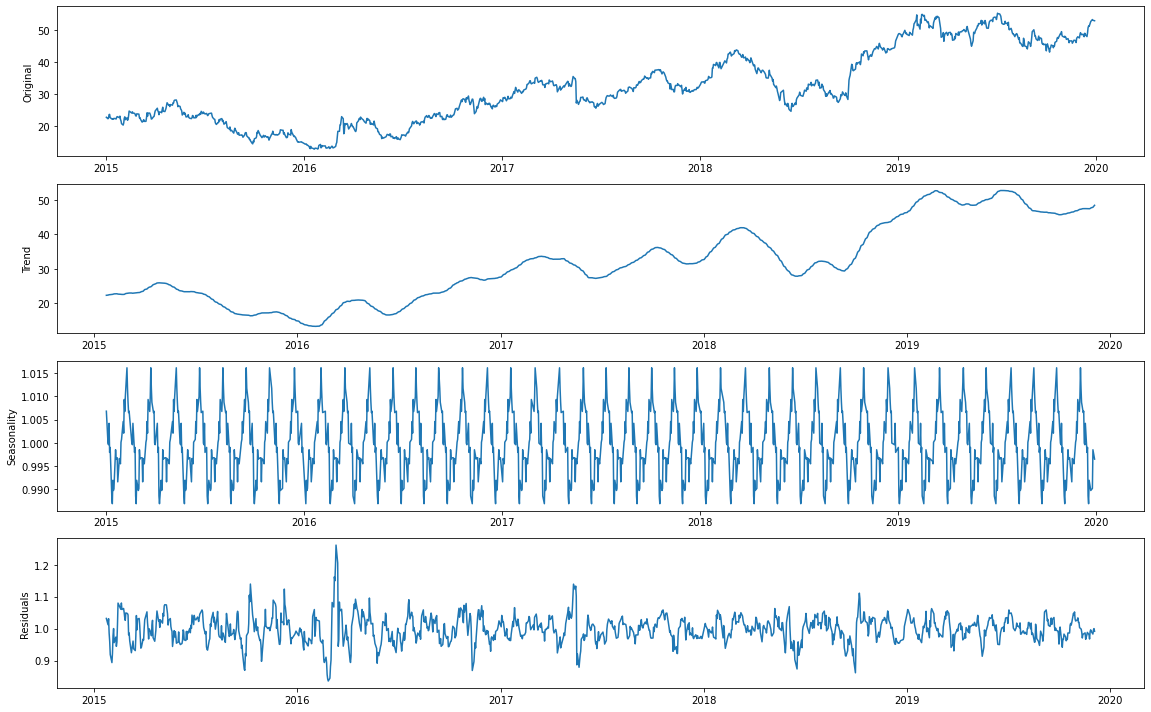

<Figure size 432x288 with 0 Axes>

In [34]:
# Decomposição da série temporal

decomposition = seasonal_decompose(train_bbas3_arima, model='multiplicative', period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(16,10))
plt.subplot(411)
plt.plot(train_bbas3_arima)
plt.ylabel('Original')
plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonality')
plt.subplot(414)
plt.plot(residual)
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

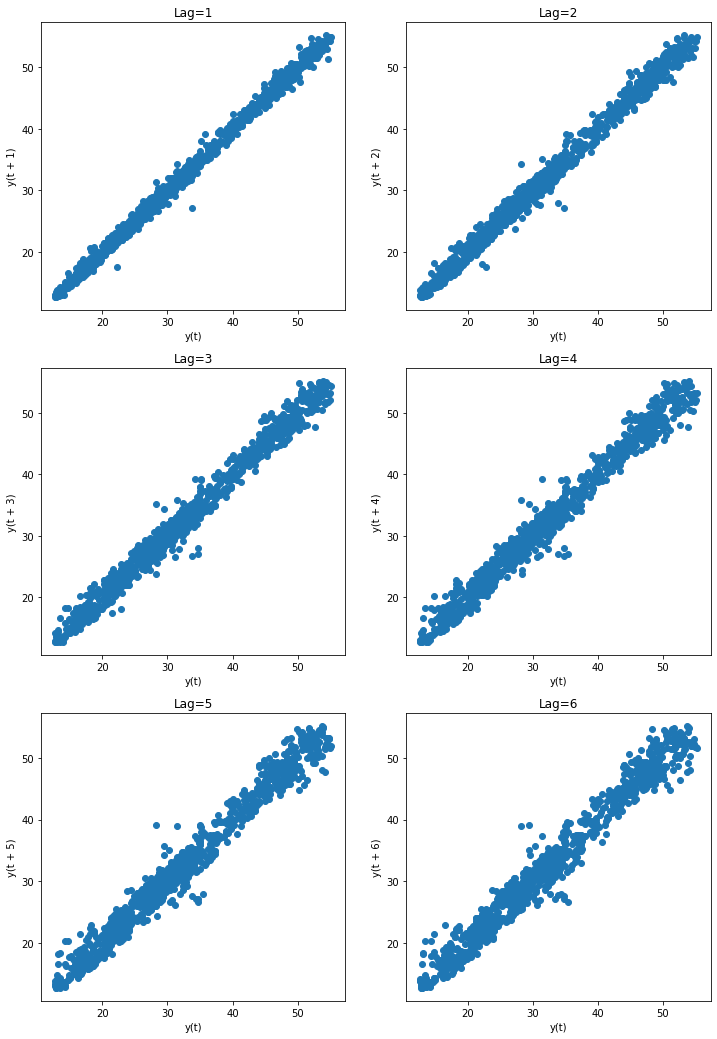

<Figure size 432x288 with 0 Axes>

In [35]:
# Plotagem da Autocorrelação

fig, axes = plt.subplots(3, 2, figsize=(12, 18))
plt.title('Autocorrelação da ação BBAS3')

# Coordenadas dos eixos para plotagem

ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(train_bbas3_arima["Close"], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.show()

<p>Como a plotagem da autocorrelação parece bem linear, um modelo auto-regressivo poderia ser uma boa escolha. Mas ainda sim será utilizado o modelo auto-arima para identificação do melhor modelo de forma automática.</p>

In [36]:
# Função para verificar a estacionaridade

def adf_test(y):
    print('Resultado do Teste Dickey-Fuller:')
    dftest = adfuller(y, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=['Teste','Valor p', 'Nº de lags', 'Nº de observações'])
    for key, value in dftest[4].items():
        dfoutput['Valor Crítico ({})'.format(key)] = value
    print(dfoutput)

adf_test(train_bbas3_arima)

Resultado do Teste Dickey-Fuller:
Teste                    -0.650803
Valor p                   0.859085
Nº de lags                0.000000
Nº de observações      1242.000000
Valor Crítico (1%)       -3.435626
Valor Crítico (5%)       -2.863870
Valor Crítico (10%)      -2.568010
dtype: float64


<p>Com o resultado do teste Dickey-Fuller e pela análise do gráfico, conclui-se que a série não é estacionária. Com isso, pode-se tentar diferenciar a série para transformá-la em estacionária.</p>

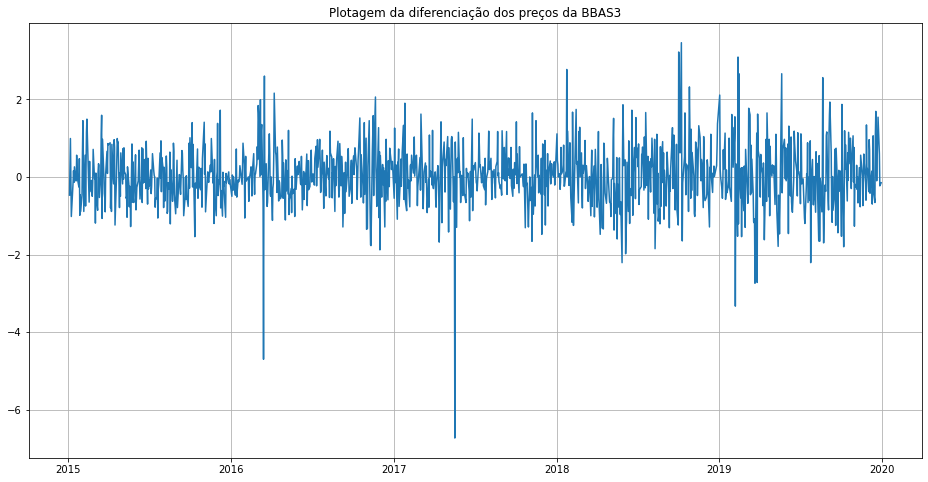

In [37]:
# Aplicação da diferenciação

train_bbas3_arima_diff = train_bbas3_arima - train_bbas3_arima.shift()
train_bbas3_arima_diff.dropna(inplace=True)

# Plotagem da diferenciação de primeira ordem da BBAS3

plt.figure(figsize=(16,8))
plt.plot(train_bbas3_arima_diff)
plt.title('Plotagem da diferenciação dos preços da BBAS3')
plt.grid(True)

In [38]:
# Teste de Dickey-Fuller para série diferenciada

adf_test(train_bbas3_arima_diff)

Resultado do Teste Dickey-Fuller:
Teste                   -34.941323
Valor p                   0.000000
Nº de lags                0.000000
Nº de observações      1241.000000
Valor Crítico (1%)       -3.435630
Valor Crítico (5%)       -2.863872
Valor Crítico (10%)      -2.568011
dtype: float64


<p>Com o teste Dickey-Fuller e plotagem dos gráficos verifica-se que a série diferenciada é estacionária.</p>

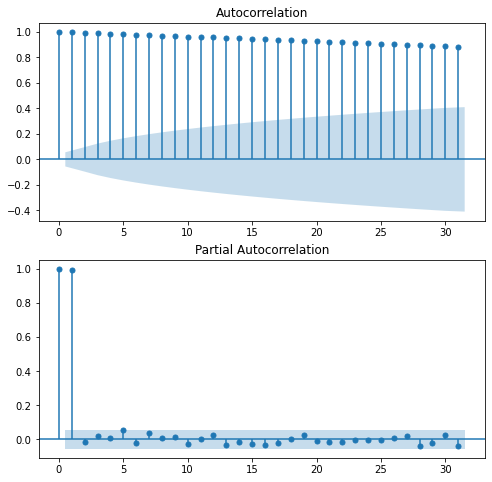

<Figure size 432x288 with 0 Axes>

In [39]:
# Plotagem dos gráficos ACF e PACF

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(train_bbas3_arima, ax = ax1)
plot_pacf(train_bbas3_arima, ax = ax2)
plt.show()

<p>Utilizando-se o fato da série ser estacionária para uma diferenciação de primeira ordem (d=1), pode-se utilizar a função auto_arima para determinar o melhor modelo que se adequa à série temporal estudada.</p>

<p><b>Principais parâmetros do modelo Auto-Arima:</b></p>
<p>p = número de time lags do modelo auto-regressivo (AR)</p>
<p>q = ordem do modelo de média-móvel (MA)</p>
<p>d = grau de diferenciação</p>
<p>P = refere-se ao termo auto-regressivo para a parte sazonal</p> 
<p>Q = refere-se ao termo de diferenciação para a parte sazonal</p>
<p>D = refere-se ao termo da média-móvel para a parte sazonal</p> 

In [40]:
# Definição do modelo

model = pm.auto_arima(train_bbas3_arima['Close'], start_p=1, start_q=1,
                      #test='adf',       # usa o adftest para encontrar o melhor valor 'd'
                      max_p=3, max_q=3, # Máximo 'p' e 'q'
                      m=12,              # Frequência da série
                      d=1,           
                      stationary = False, #Estacionaridade
                      seasonal=True, #Sazonalidade
                      start_P=0, 
                      D=1, 
                      trace=True, #Se TRUE, a lista de modelos ARIMA considerados será reportada.
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) #Se TRUE, fará a seleção gradual (mais rápido). Caso contrário, ele pesquisará todos os modelos.

# Treinamento do modelo

model.fit(train_bbas3_arima['Close'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.93 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3723.054, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3407.737, Time=0.40 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3724.939, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3292.095, Time=0.92 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.91 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.65 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3290.328, Time=0.84 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=3405.960, Time=0.32 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=6.74 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=3292.080, Time=1.19 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=13.37 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=3292.300, 

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [41]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1243
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1642.164
Date:                            Mon, 30 May 2022   AIC                           3290.328
Time:                                    16:09:48   BIC                           3305.672
Sample:                                         0   HQIC                          3296.101
                                           - 1243                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6261      0.022    -28.439      0.000      -0.669      -0.583
ar.S.L24      -0.3041      0.023   

In [42]:
# Faz a predição 

forecast_arima = model.predict(n_periods=len(test_bbas3_arima['Close']))
forecast_arima = pd.DataFrame(forecast_arima, index = test_bbas3_arima.index,columns=['Prediction'])
conf_int = model.predict(len(test_bbas3_arima['Close']), return_conf_int=True, alpha = 0.05) #Pega o intervalo de confiança

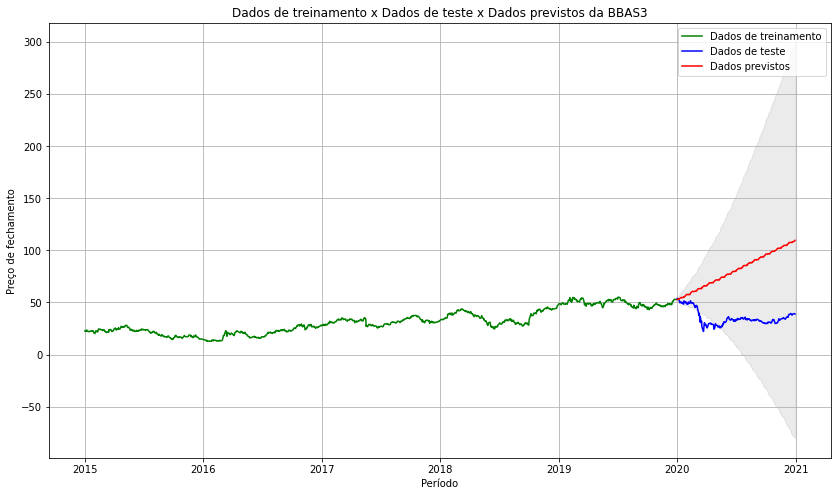

In [43]:
# Plotagem dos dados de treinamento, teste e previsão

plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos da BBAS3')
plt.plot(train_bbas3_arima['Close'], color='green', label = 'Dados de treinamento')
plt.plot(test_bbas3_arima['Close'], color = 'blue', label = 'Dados de teste')
plt.fill_between(test_bbas3_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
plt.show()

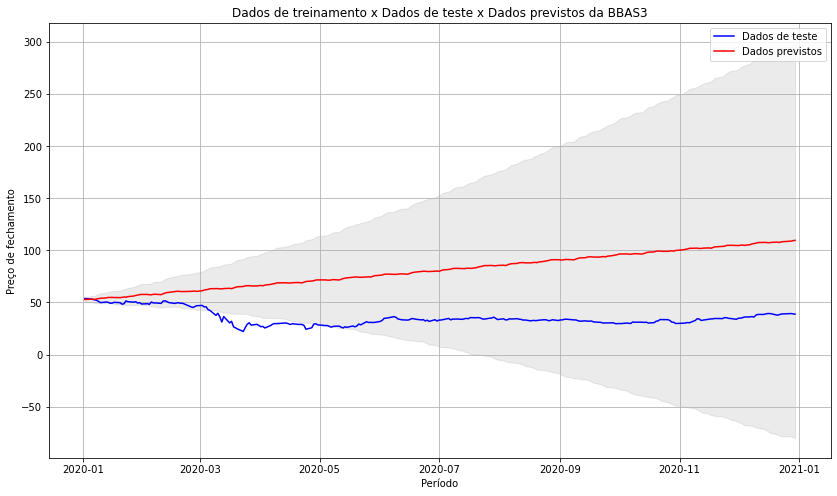

In [44]:
# Plotagem dos dados de teste e previsão

plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos da BBAS3')
plt.plot(test_bbas3_arima['Close'], color = 'blue', label = 'Dados de teste')
plt.fill_between(test_bbas3_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Cálculo do erro

mse = mean_squared_error(test_bbas3_arima['Close'], forecast_arima['Prediction'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_bbas3_arima['Close'], forecast_arima['Prediction'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_bbas3_arima['Close'], forecast_arima['Prediction']))
print('RMSE: '+str(rmse))

MSE: 2501.673953921535
MAE: 45.50693289641339
RMSE: 50.01673673803135


<AxesSubplot:>

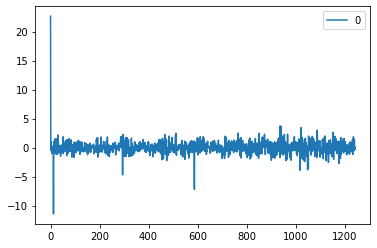

In [47]:
# Plotagem dos resíduos

residuals = pd.DataFrame(model.resid())
residuals.plot()

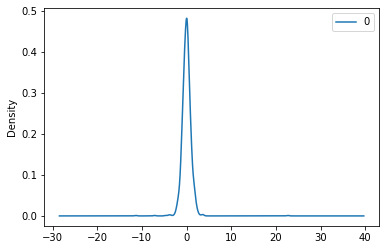

                 0
count  1243.000000
mean      0.013678
std       1.164862
min     -11.425000
25%      -0.542903
50%       0.006450
75%       0.516630
max      22.650000


<Figure size 432x288 with 0 Axes>

In [48]:
# Plotagem da densidade dos resíduos

residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

<h3>Modelo preditivo com RNN com arquitetura LSTM (Long Short Term Memory)</h3>

In [49]:
# Carregamento dos dados

train_bbas3_lstm = train_dataset_bbas3
train_bbas3_lstm = train_bbas3_lstm.drop(['Adj Close','Open','Low','High','Volume'], axis=1)
test_bbas3_lstm = test_dataset_bbas3
test_bbas3_lstm = test_bbas3_lstm.drop(['Adj Close','Open','Low','High','Volume'], axis=1)
train_bbas3_lstm.head()

,Close
Date,
2015-01-02,22.650000
2015-01-05,22.180000
2015-01-06,22.490000
2015-01-07,23.480000
2015-01-08,23.559999


In [50]:
# Normalização dos dados

train_lstm = train_bbas3_lstm.iloc[:,0:1].values# seleciona o preço de fechamento
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled_lstm = scaler.fit_transform(train_lstm) 
train_scaled_lstm

array([[0.23422786],
       [0.22316385],
       [0.23046139],
       ...,
       [0.95338984],
       [0.94797554],
       [0.94444443]])

In [51]:
# Criação de uma estrutura de dados com 60 timesteps e 1 saída, que neste caso será o preço de fechamento da ação

timesteps = 60
x_train_lstm = []
y_train_lstm = []
for i in range(timesteps, train_lstm.shape[0]):
    x_train_lstm.append(train_scaled_lstm[i-timesteps:i, 0]) # Utilização de 60 timesteps anteriores
    y_train_lstm.append(train_scaled_lstm[i, 0]) # O 120º preço de fechamento será o valor de y
x_train_lstm, y_train_lstm = np.array(x_train_lstm), np.array(y_train_lstm)

In [52]:
# Reshaping o dataset de treinamento
# Sendo o segundo parâmetro como:

       # x_train_lstm.shape[0] = batch_size, que é o número de preços de ações do período de treinamento
       # x_train_lstm.shape[1] = time_step, que é o número de preços anteriores
       # input_dim = 1, que indica que será usado o preço de fechamento
x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], x_train_lstm.shape[1], 1))

In [57]:
# Criação da LSTM utilizando a biblioteca Keras

seed=2016
np.random.seed (seed)

# Inicialização da RNN

model_rnn = Sequential()

# O parâmetro return_sequences=True indica que a rede terá mais camadas a frente
# O parâmetro Dropout ajuda no ajuste do Overfitting

# Adiciona a primeira camada LSTM com o Dropout

model_rnn.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train_lstm.shape[1], 1)))
model_rnn.add(Dropout(0.3))

# Adiciona a segunda camada LSTM com o Dropout

model_rnn.add(LSTM(units = 64))
model_rnn.add(Dropout(0.3))

# Adiciona a camada de saída

#model_rnn.add(Dense(16,init='uniform',activation='relu'))
model_rnn.add(Dense(1,activation='linear'))

# Compila a RNN, neste caso utilizando o otimizador 'Adam'

model_rnn.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

# Faz o treinamento da RNN utilizando o dataset de treinamento

model_rnn.fit(x_train_lstm, y_train_lstm, epochs = 100, batch_size = 32) 

# Mostra o resumo do modelo

model_rnn.summary()

Epoch 1/100
37/37 [==============================] - 5s 68ms/step - loss: 0.0394 - mean_absolute_error: 0.1276
Epoch 2/100
37/37 [==============================] - 2s 60ms/step - loss: 0.0054 - mean_absolute_error: 0.0542
Epoch 3/100
37/37 [==============================] - 3s 88ms/step - loss: 0.0050 - mean_absolute_error: 0.0524
Epoch 4/100
37/37 [==============================] - 3s 88ms/step - loss: 0.0048 - mean_absolute_error: 0.0510
Epoch 5/100
37/37 [==============================] - 4s 97ms/step - loss: 0.0041 - mean_absolute_error: 0.0477
Epoch 6/100
37/37 [==============================] - 4s 102ms/step - loss: 0.0043 - mean_absolute_error: 0.0484
Epoch 7/100
37/37 [==============================] - 3s 94ms/step - loss: 0.0038 - mean_absolute_error: 0.0456
Epoch 8/100
37/37 [==============================] - 3s 87ms/step - loss: 0.0045 - mean_absolute_error: 0.0494
Epoch 9/100
37/37 [==============================] - 3s 89ms/step - loss: 0.0040 - mean_absolute_error: 0.0465


In [70]:
# Visualização do modelo

plot_model(model_rnn, show_shapes=True) # Acrescente o parâmetro 'to_file='model_rnn.png' para exportar a figura

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [71]:
# Carregamento dos dados de teste para fazer as predições

test_lstm = test_bbas3_lstm.iloc[:,0:1].values #seleciona o preço de fechamento

In [72]:
# Concatena os dados de treinamento e teste, pois os preços de fechamento anteriores não estão no conjunto de teste

combine = pd.concat((train_bbas3_lstm['Close'], test_bbas3_lstm['Close']), axis = 0)

# Tratamento do conjunto de teste considerando os timesteps anteriores

test_inputs = combine[len(combine) - len(test_bbas3_lstm) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Normalização dos dados

test_inputs = scaler.transform(test_inputs)

In [73]:
# Predição utilizando os dados de teste

x_test_lstm = []
for i in range(timesteps, test_bbas3_lstm.shape[0]+timesteps):
    x_test_lstm.append(test_inputs[i-timesteps:i, 0])
x_test_lstm = np.array(x_test_lstm)
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))
predictions_lstm = model_rnn.predict(x_test_lstm)

# Desnormaliza os dados

predictions_lstm = scaler.inverse_transform(predictions_lstm)

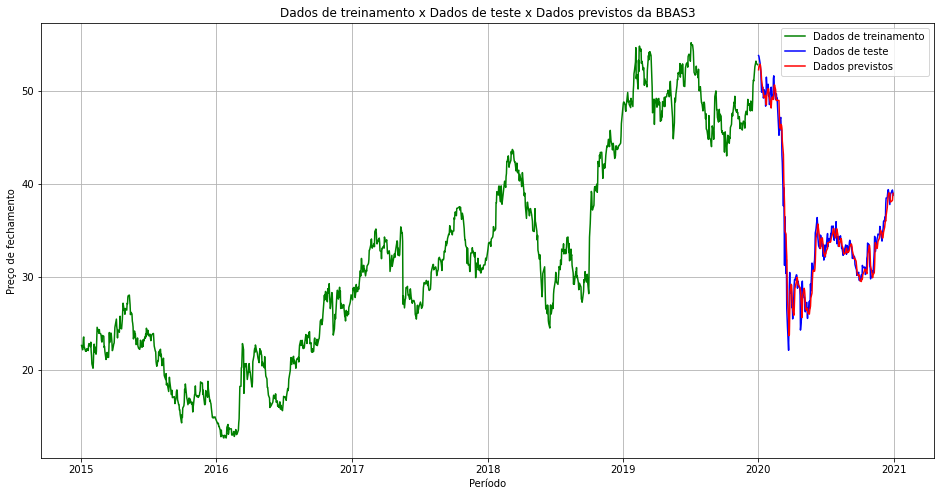

In [74]:
# Plotagem dos dados de treinamento, teste e previsão

plt.figure(figsize=(16,8))
plt.plot(train_bbas3_lstm.index, train_bbas3_lstm, color='green', label = 'Dados de treinamento')
plt.plot(test_bbas3_lstm.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(test_bbas3_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos da BBAS3')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
plt.show()

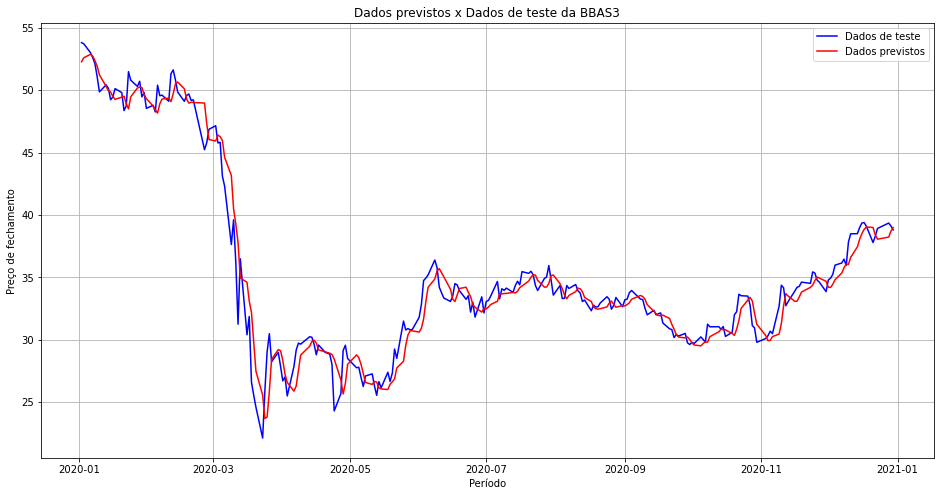

In [75]:
# Plotagem dos dados de teste e dados previstos

plt.figure(figsize=(16,8))
plt.plot(test_bbas3_lstm.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(test_bbas3_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste da BBAS3')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
plt.savefig('Figura 36 - teste-previsao-lstm.jpg')
plt.show()

In [76]:
# Cálculo do erro

print('MAE: ', mean_absolute_error(test_lstm,predictions_lstm))
print('MSE: ', mean_squared_error(test_lstm,predictions_lstm))
print('RMSE: ', np  .sqrt(mean_squared_error(test_lstm,predictions_lstm)))

MAE:  0.9820623782373243
MSE:  2.084814245462894
RMSE:  1.4438885848509553


<h3>Modelo LSTM treinado utilizado nos dados futuros</h3>

In [ ]:
# Teste do modelo treinado para os dados dos meses de Janeiro, Fevereiro e Março/2021

future_test_bbas3_lstm = data.DataReader(actions[0], 'yahoo', '2021-01-01', '2021-03-31')
future_test_bbas3_lstm = future_test_bbas3_lstm.drop(['Adj Close','Open','Low','High','Volume'], axis=1)
future_test_bbas3_lstm.head()

In [ ]:
# Concatena os dados de treinamento e teste, pois os preços de fechamento anteriores não estão no conjunto de teste

combine = pd.concat((test_bbas3_lstm[-timesteps:]['Close'], future_test_bbas3_lstm['Close']), axis = 0)

# Tratamento do conjunto de teste considerando os timesteps anteriores

test_inputs = combine[len(combine) - len(future_test_bbas3_lstm['Close']) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Normalização dos dados

test_inputs = scaler.transform(test_inputs)

In [ ]:
# Predição utilizando os dados de teste futuro

x_test_lstm = []
for i in range(timesteps, future_test_bbas3_lstm.shape[0]+timesteps):
    x_test_lstm.append(test_inputs[i-timesteps:i, 0])
x_test_lstm = np.array(x_test_lstm)
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))
predictions_lstm = model_rnn.predict(x_test_lstm)

# Desnormaliza os dados

predictions_lstm = scaler.inverse_transform(predictions_lstm)

In [ ]:
# Plotagem dos dados da janela, dados de teste futuro e dados previstos

plt.figure(figsize=(16,8))
plt.plot(combine.index, combine.values, color = 'green', label = 'Dados da janela')
plt.plot(future_test_bbas3_lstm.index, future_test_bbas3_lstm, color = 'blue', label = 'Dados de teste futuro')
plt.plot(future_test_bbas3_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste futuro da BBAS3')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
#plt.savefig('lstm3.pdf')
plt.show()

In [ ]:
# Plotagem dos dados de teste e dados previstos

plt.figure(figsize=(16,8))
plt.plot(future_test_bbas3_lstm.index, future_test_bbas3_lstm, color = 'blue', label = 'Dados de teste futuro')
plt.plot(future_test_bbas3_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste futuro da BBAS3')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
#plt.savefig('lstm4.pdf')
plt.show()

In [ ]:
# Cálculo do erro

print('MAE: ', mean_absolute_error(future_test_bbas3_lstm,predictions_lstm))
print('MSE: ', mean_squared_error(future_test_bbas3_lstm,predictions_lstm))
print('RMSE: ', np.sqrt(mean_squared_error(future_test_bbas3_lstm,predictions_lstm)))